In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", message="An unsupported index was provided")

In [2]:
final_matrix_labeled = pd.read_parquet('data/model_data/final_matrix_tha_labeled.parquet').query("Event_class == 3")
event_df = pd.read_csv('data/event_data/event_data_tha_avg.csv').query("event_class == 3").reset_index(drop=True)

In [3]:
event_df

,satellite_name,start_time,end_time,event_duration,max_velocity,avg_|Bx|,avg_|Bz|,event_class
0,THEMIS A,2008-01-19 00:43:52.831619740+00:00,2008-01-19 00:55:58.965564966+00:00,12.102232,146.259084,21.032516,7.551622,3
1,THEMIS A,2008-01-19 01:25:40.495678663+00:00,2008-01-19 01:40:52.827654600+00:00,15.205533,158.023657,25.602554,5.020730,3
2,THEMIS A,2008-01-19 20:30:19.152644873+00:00,2008-01-19 20:52:31.954259872+00:00,22.213360,126.336174,53.216785,8.584009,3
3,THEMIS A,2008-01-19 20:59:00.035024643+00:00,2008-01-19 21:13:54.356933594+00:00,14.905365,188.487296,48.516045,6.580752,3
4,THEMIS A,2008-01-21 12:02:22.142283678+00:00,2008-01-21 12:16:01.392052412+00:00,13.654163,100.956480,25.550468,7.113010,3
...,...,...,...,...,...,...,...,...
8075,THEMIS A,2025-01-13 16:08:00.877534151+00:00,2025-01-13 17:37:20.250792026+00:00,89.322888,405.347323,26.919996,3.357577,3
8076,THEMIS A,2025-01-13 18:01:30.948851109+00:00,2025-01-13 18:19:58.140263319+00:00,18.453190,120.781238,29.750345,1.950956,3
8077,THEMIS A,2025-01-14 18:40:19.733319283+00:00,2025-01-14 19:03:18.341272593+00:00,22.976799,194.902896,33.802425,0.457164,3
8078,THEMIS A,2025-01-14 19:37:04.772624493+00:00,2025-01-14 20:28:06.709553242+00:00,51.032282,294.274501,43.803581,2.251472,3


In [ ]:
# Maps each event's start and end time in `event_df` to index ranges in `final_matrix_labeled` using UNIX timestamps
# Appends the indices of the matching rows for each event into `event_indices`

tha_start_time = (pd.to_datetime(event_df['start_time']).astype('int64') / 10**9).values
tha_end_time = (pd.to_datetime(event_df['end_time']).astype('int64') / 10**9).values

event_indices = []

for idx, row in event_df.iterrows():
    start_idx = np.searchsorted(final_matrix_labeled['Epoch_time'], tha_start_time[idx], side='left')
    end_idx = np.searchsorted(final_matrix_labeled['Epoch_time'], tha_end_time[idx], side='right')

    event_indices.append(final_matrix_labeled.iloc[start_idx:end_idx].index.values)

In [5]:
random.seed(18)
event_sample = random.sample(list(range(0, len(event_indices))), 10)

# EDA

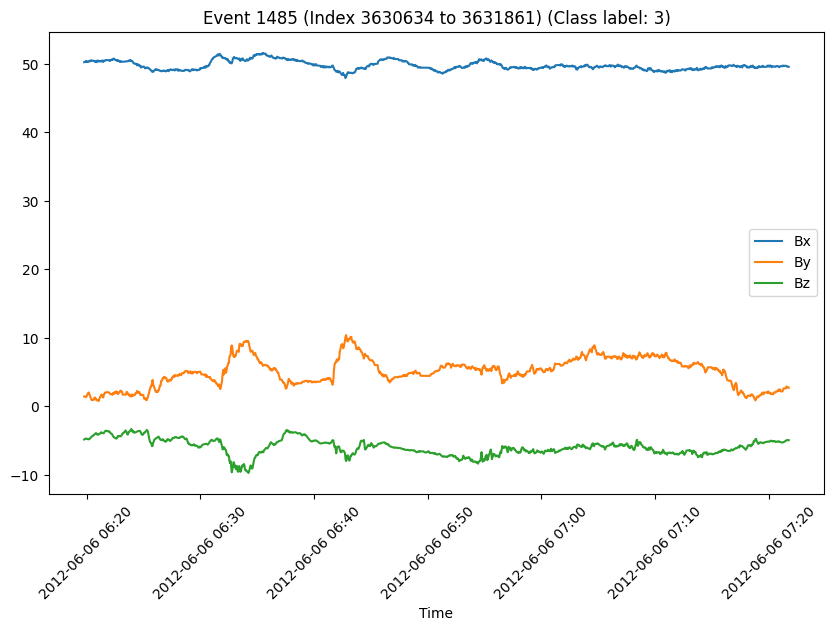

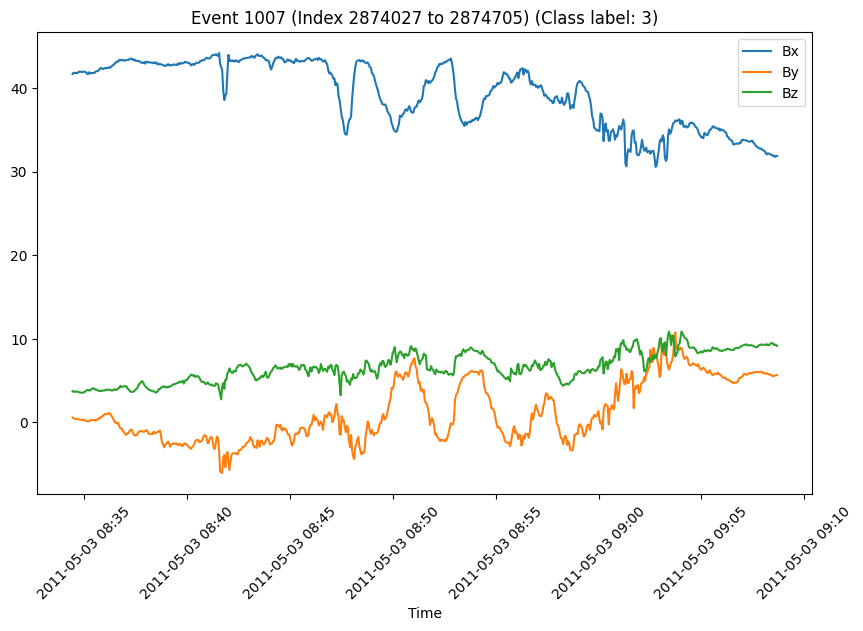

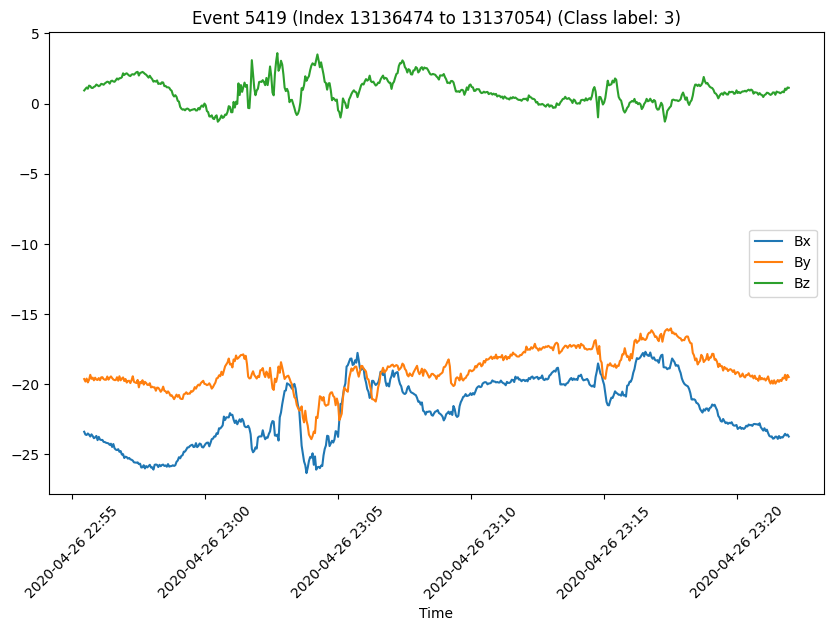

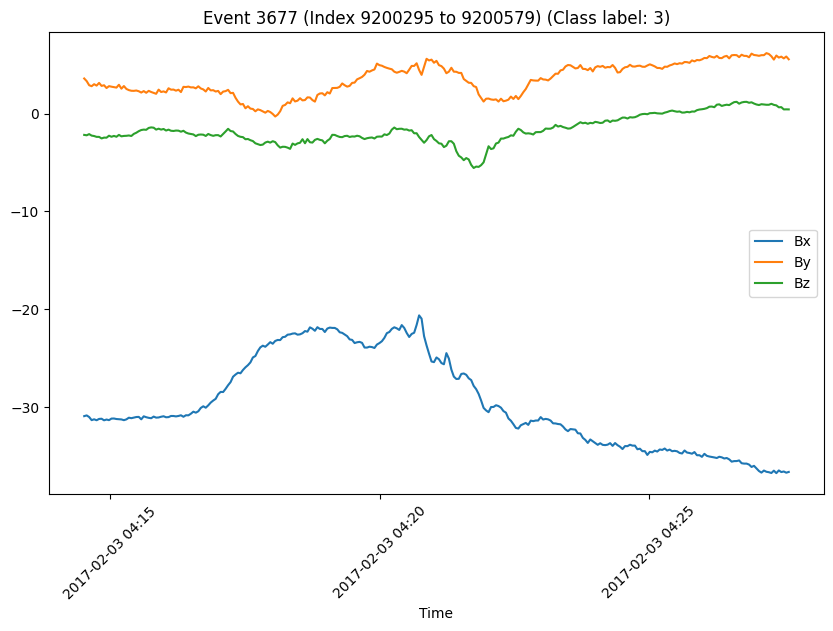

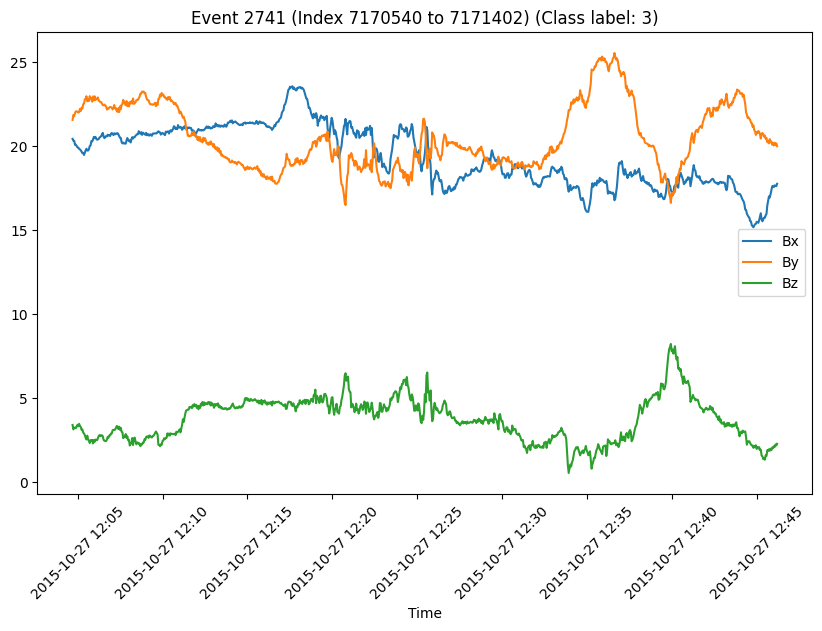

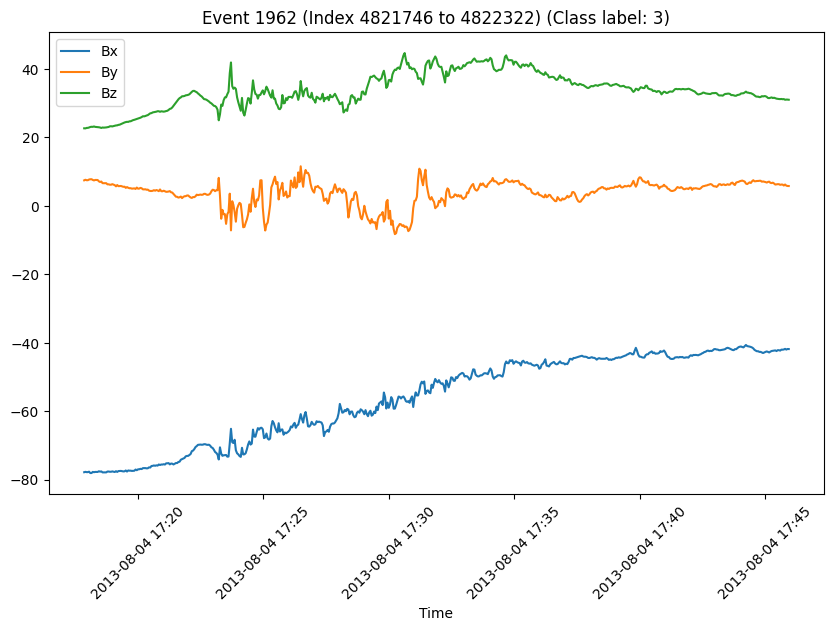

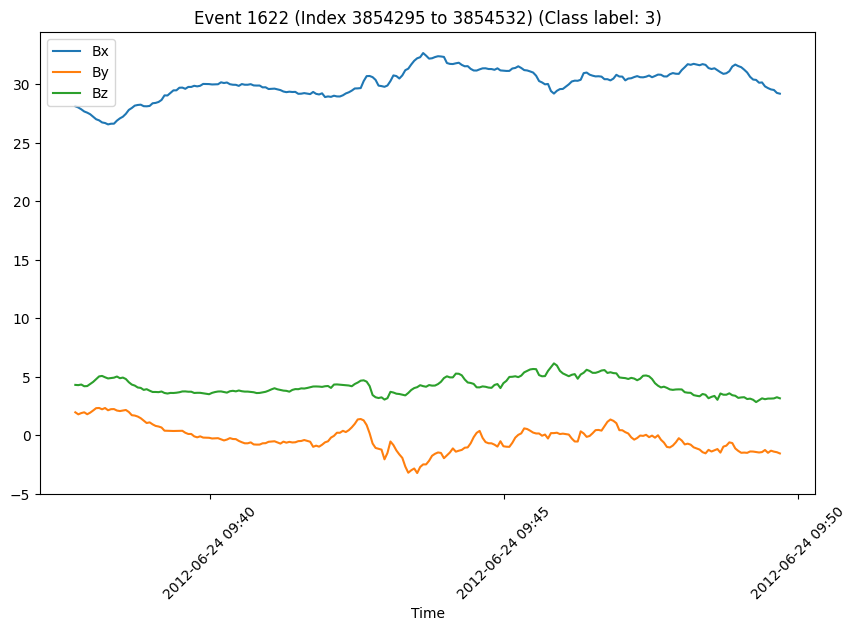

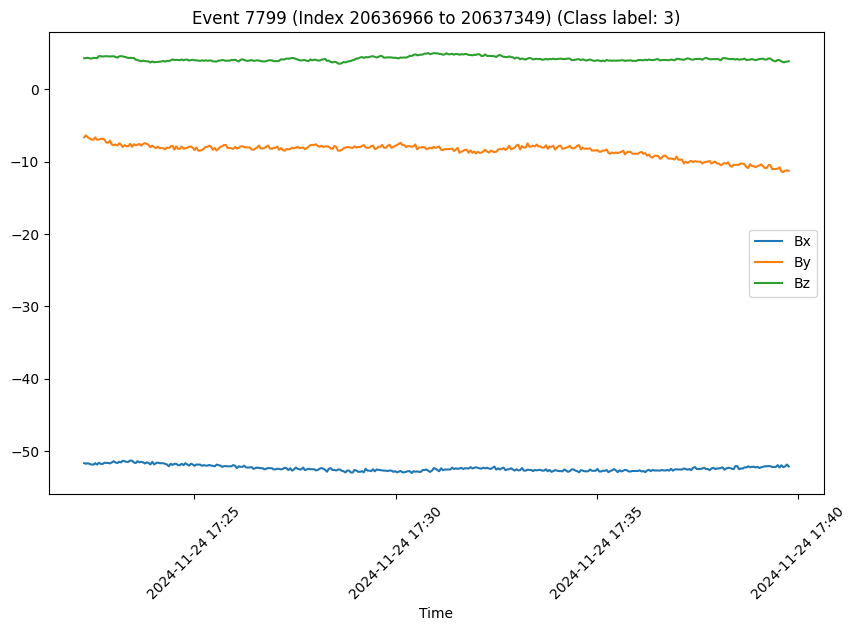

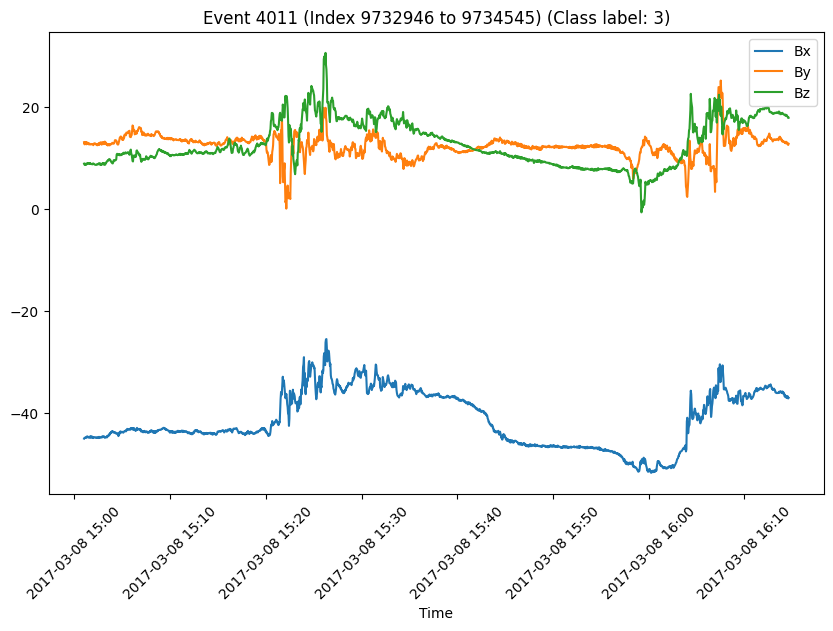

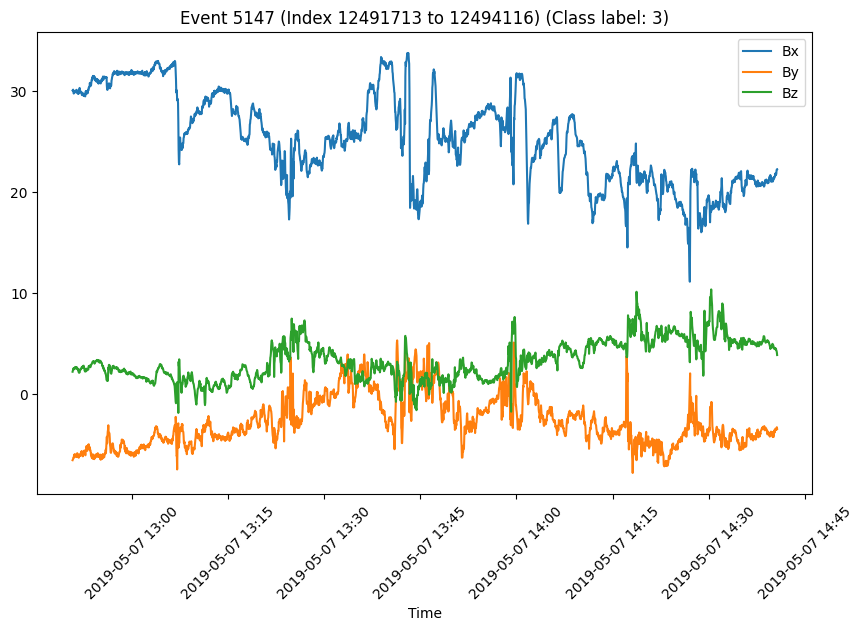

In [ ]:
# Plots the magnetic field components (Bx, By, Bz) over time for each sampled event 

for i in event_sample:
    rand_event_df = final_matrix_labeled.loc[event_indices[i][0]:event_indices[i][-1]]

    plt.figure(figsize=(10, 6))
    plt.plot(rand_event_df['Time'], rand_event_df['Bx'], label='Bx', color='blue')
    plt.plot(rand_event_df['Time'], rand_event_df['By'], label='Bx', color='limegreen')
    plt.plot(rand_event_df['Time'], rand_event_df['Bz'], label='Bx', color='red')
    plt.xlabel('Time')
    plt.legend()
    plt.title(f"Event {i + 1} (Index {event_indices[i][0]} to {event_indices[i][-1]}) (Class label: {np.max(rand_event_df['Event_class'])})")
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

    plt.show()

# VAR
A VAR model captures linear relationships between multiple time series by using its own past values and the past values of other series

PACF plot shows a sharp cutoff after 2 lags, so at most 2 lags would be sufficient to capture individual temporal effects within the magnetic field components.


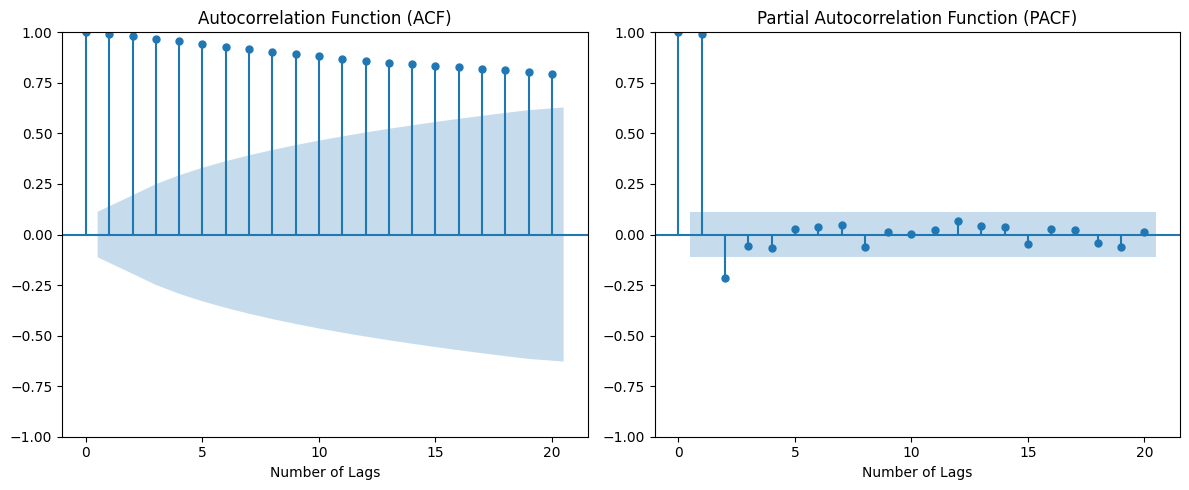

In [ ]:
# Plots the ACF and PACF of the 'Bx' magnetic field component to analyze its temporal autocorrelations

time_series = final_matrix_labeled.loc[event_indices[1][0]:event_indices[1][-1], ['Epoch_time', 'Bx', 'By', 'Bz', 'Event_class']]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(time_series['Bx'], lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Number of Lags')

plot_pacf(time_series['Bx'], lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Number of Lags')

plt.tight_layout()
plt.show()

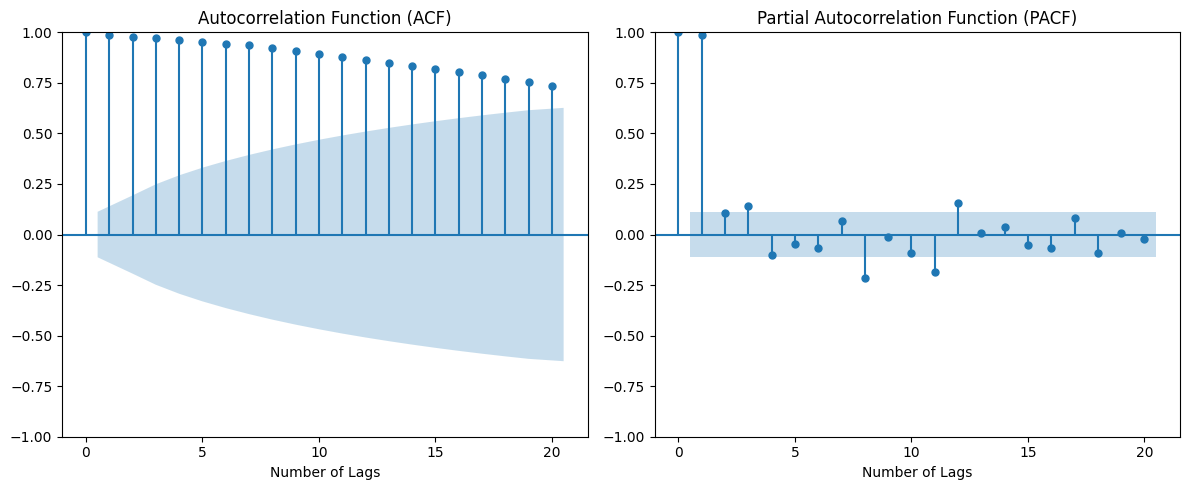

In [ ]:
# Plots the ACF and PACF of the 'By' magnetic field component to analyze its temporal autocorrelations

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(time_series['By'], lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Number of Lags')

plot_pacf(time_series['By'], lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Number of Lags')

plt.tight_layout()
plt.show()

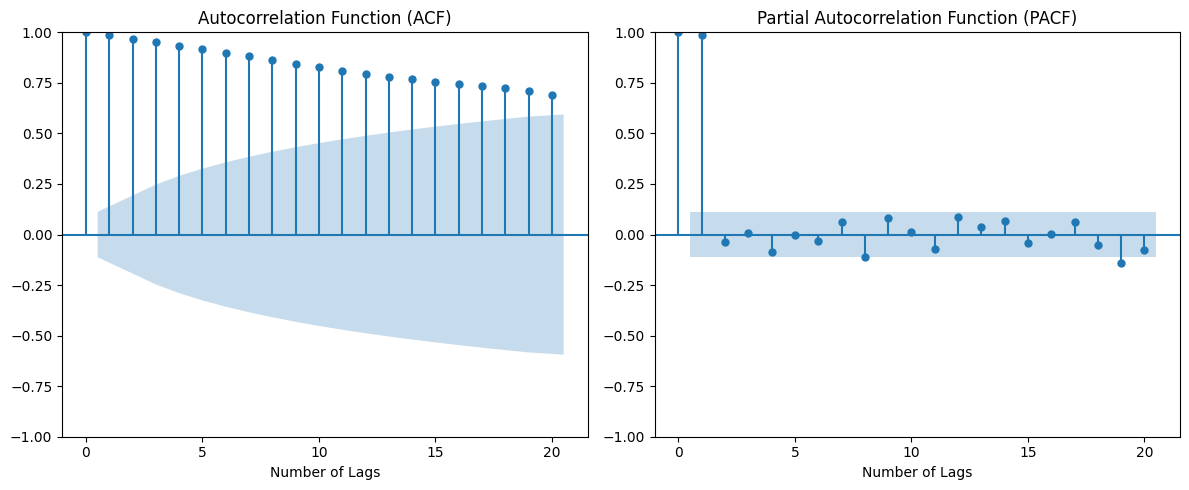

In [ ]:
# Plots the ACF and PACF of the 'Bz' magnetic field component to analyze its temporal autocorrelations

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(time_series['Bz'], lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Number of Lags')

plot_pacf(time_series['Bz'], lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Number of Lags')

plt.tight_layout()
plt.show()

In [ ]:
# Fits a VAR model with up to 2 lags on magnetic field components (Bx, By, Bz) for each sampled event

for i in event_sample:
    rand_event_df = final_matrix_labeled.loc[event_indices[i][0]:event_indices[i][-1], ['Bx', 'By', 'Bz']]
    
    var_model = VAR(rand_event_df)
    var_model_fitted = var_model.fit(maxlags=2)

    print(var_model_fitted.summary(), "\n")

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 29, Mar, 2025
Time:                     11:58:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.0064
Nobs:                     1215.00    HQIC:                  -24.0614
Log likelihood:           9486.43    FPE:                3.43440e-11
AIC:                     -24.0946    Det(Omega_mle):     3.37572e-11
--------------------------------------------------------------------
Results for equation Bx
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000083         0.000353           -0.234           0.815
L1.Bx         0.721003         0.029779           24.212           0.000
L1.By        -0.033825         0.015149           -2.233           0.026
L1.Bz         0.052800

# GARCH
GARCH models capture the volatility in the magnetic field components. It captures clustering of high and low volatility periods

There are 2 main estimated coefficients by GARCH Models:
- α: Captures the reaction of volatility to recent shocks. A high α indicates that large deviations (shocks) cause a bigger increase in volatility.
- β: Represents the persistence of volatility. A high β indicates that high volatility in previous periods is likely to continue into the next period.


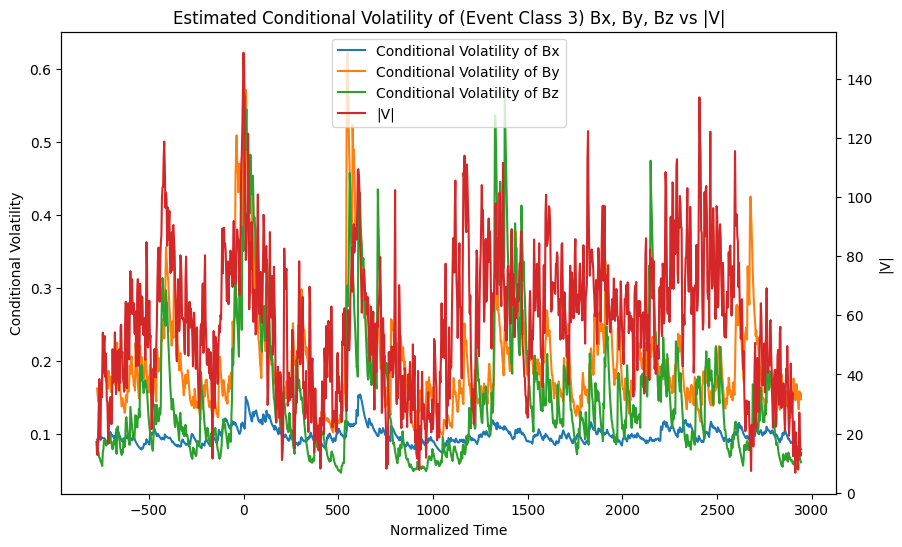

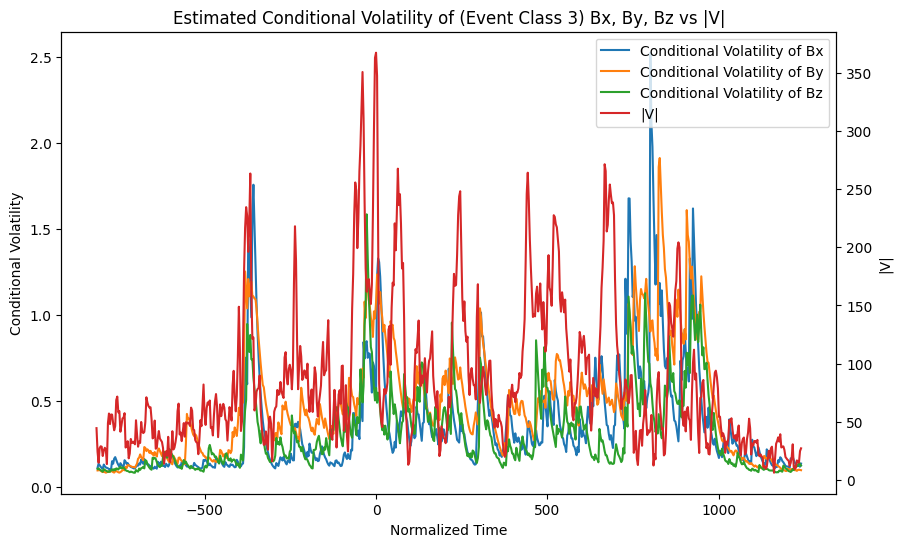

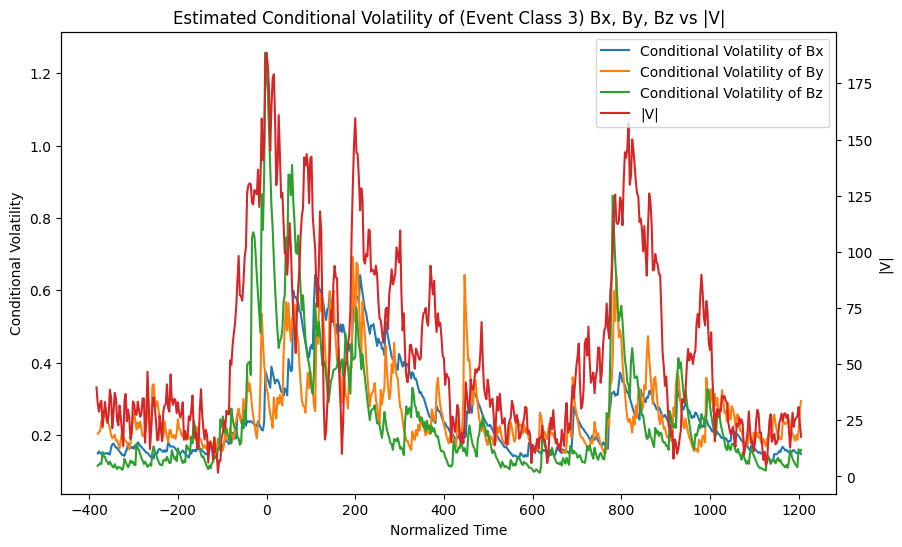

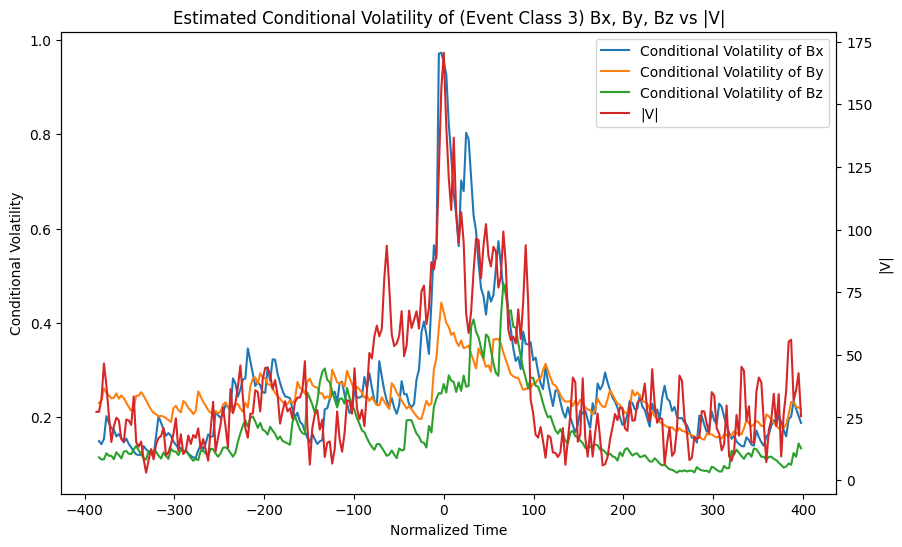

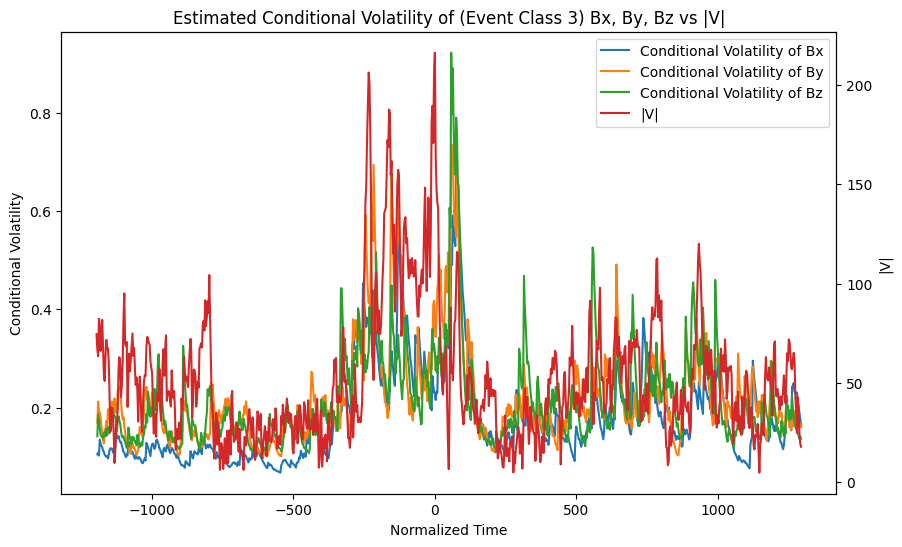

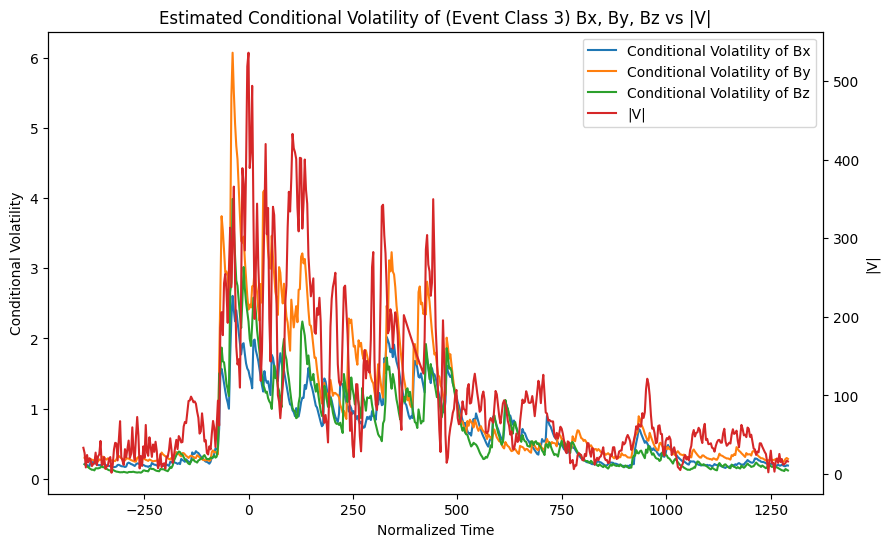

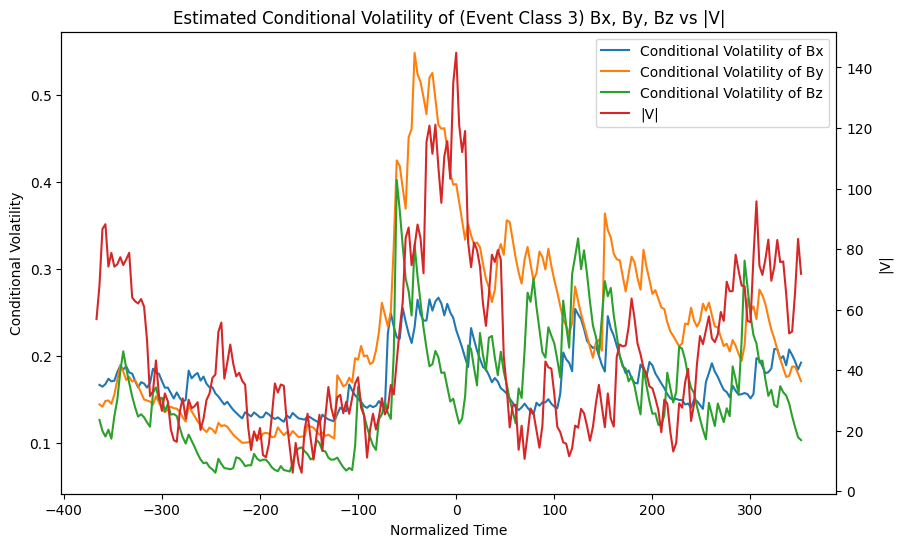

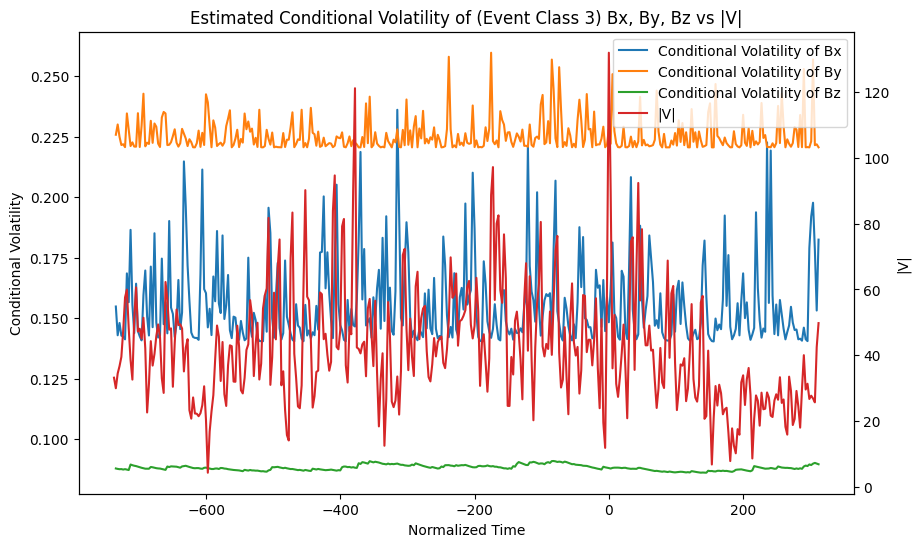

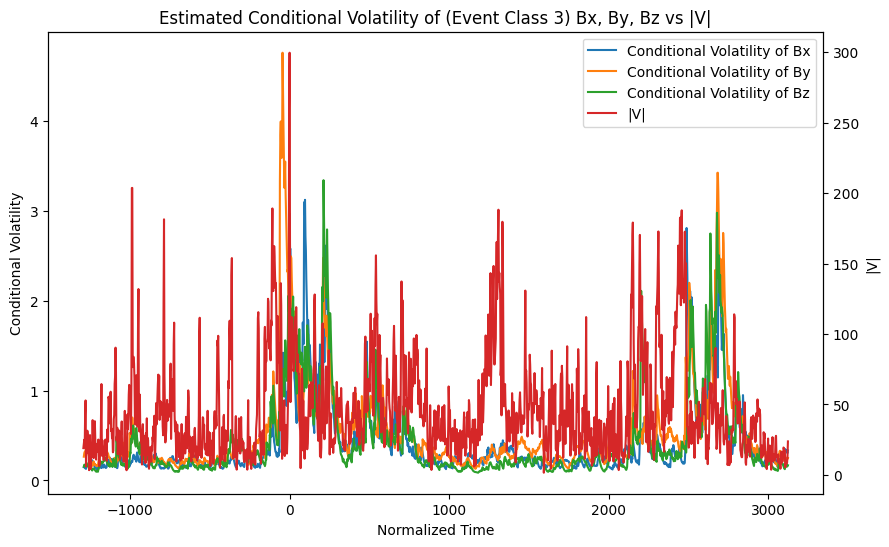

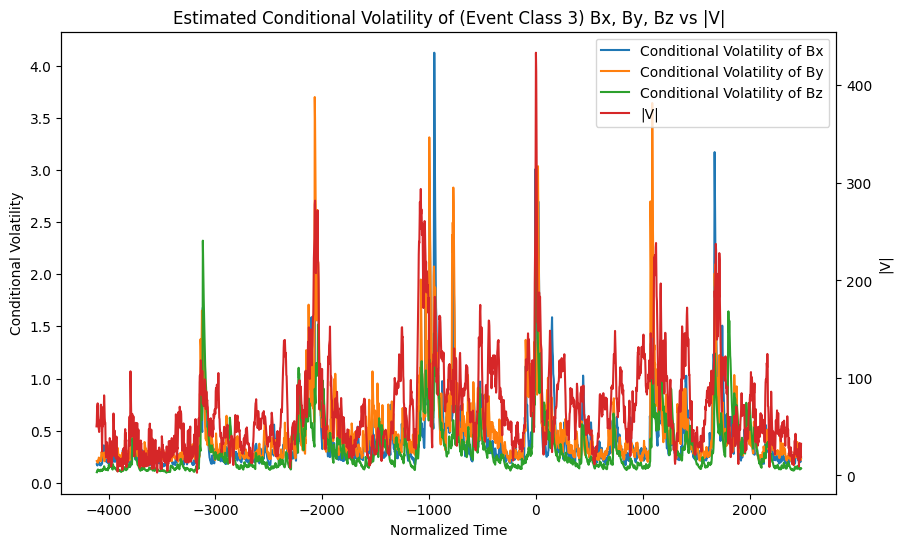

In [ ]:
# Fits AR(1)-GARCH(1,1) models to Bx, By, and Bz components for each event, aligning time by max |V| value
# Plots conditional volatilities alongside |V| over normalized time, shows similar movement to |V|

for i in event_sample:
    rand_event_df = final_matrix_labeled.loc[event_indices[i][0]:event_indices[i][-1], ['Time', 'Bx', 'By', 'Bz', '|V|']]

    max_v_index = rand_event_df['|V|'].idxmax()
    max_v_time = rand_event_df.loc[max_v_index, 'Time']

    rand_event_df['Normalized_Time'] = (rand_event_df['Time'] - max_v_time).dt.total_seconds()

    model_bx = arch_model(rand_event_df['Bx'], mean='AR', lags=1, vol='Garch', p=1, q=1, rescale=False)
    model_by = arch_model(rand_event_df['By'], mean='AR', lags=1, vol='Garch', p=1, q=1, rescale=False)
    model_bz = arch_model(rand_event_df['Bz'], mean='AR', lags=1, vol='Garch', p=1, q=1, rescale=False)
    
    model_bx_fit = model_bx.fit(disp="off", show_warning=False)
    model_by_fit = model_by.fit(disp="off", show_warning=False)
    model_bz_fit = model_bz.fit(disp="off", show_warning=False)

    # print(pd.DataFrame({
    #     'CV bx': model_bx_fit.conditional_volatility,
    #     'CV by': model_by_fit.conditional_volatility,
    #     'CV bz': model_bz_fit.conditional_volatility,
    #     'Bx': rand_event_df['Bx'],
    #     'By': rand_event_df['By'],
    #     'Bz': rand_event_df['Bz'],
    #     '|V|': rand_event_df['|V|']
    # }).corr())

    plt.figure(figsize=(10, 6), dpi=100)

    ax1 = plt.gca()
    line1, = ax1.plot(rand_event_df['Normalized_Time'], model_bx_fit.conditional_volatility, label='Conditional Volatility of Bx', color='blue')
    line2, = ax1.plot(rand_event_df['Normalized_Time'], model_by_fit.conditional_volatility, label='Conditional Volatility of By', color='limegreen')
    line3, = ax1.plot(rand_event_df['Normalized_Time'], model_bz_fit.conditional_volatility, label='Conditional Volatility of Bz', color='red')
    ax1.set_ylabel('Conditional Volatility')

    ax2 = ax1.twinx()
    line4, = ax2.plot(rand_event_df['Normalized_Time'], rand_event_df['|V|'], label='|V|', color='black')
    ax2.set_ylabel('|V|')

    plt.title('Estimated Conditional Volatility of (Event Class 3) Bx, By, Bz vs |V|')

    lines = [line1, line2, line3, line4]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='best')
    ax1.set_xlabel('Normalized Time')

    plt.show()